# InSituPy demonstration - Differential gene expression analysis

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from insitupy import read_xenium
import scanpy as sc

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Xenium data into `InSituData` object

Now the Xenium data can be parsed by providing the data path to the `InSituPy` project folder.

In [4]:
insitupy_project = Path("demo_dataset/demo_insitupy_project")

In [5]:
xd = read_xenium(insitupy_project)

In [6]:
xd.load_images()
xd.load_cells()

Loading images...
['nuclei', 'CD20', 'HER2', 'DAPI', 'HE']
Loading cells...
	No alternative cells found...


In [7]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       DAPI:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 163565 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes', 'leiden', 'annotations-TestKey', 'annotations-demo', 'annotations-demo2', 'annotations-demo3', 'cell_type'
           var: 'gene_ids', 'feature_types', 'genome'
           uns: 'cell_type_colors', 'counts_location', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
           obsm: 'OT', 'X_pca', 'X_umap', 'spatial'
           varm: 'OT', 'PCs', 'binned_expression'
           layers: 'counts', 'norm_counts'
           obsp: 'connec

In [8]:
xd.import_annotations(
    files="./demo_annotations/demo_annotations.geojson",
    keys="Demo"
)

Importing annotations...


In [9]:
xd.import_regions(
    files="./demo_regions/demo_regions.geojson",
    keys="Demo"
)

Importing regions...


### Visualize annotations
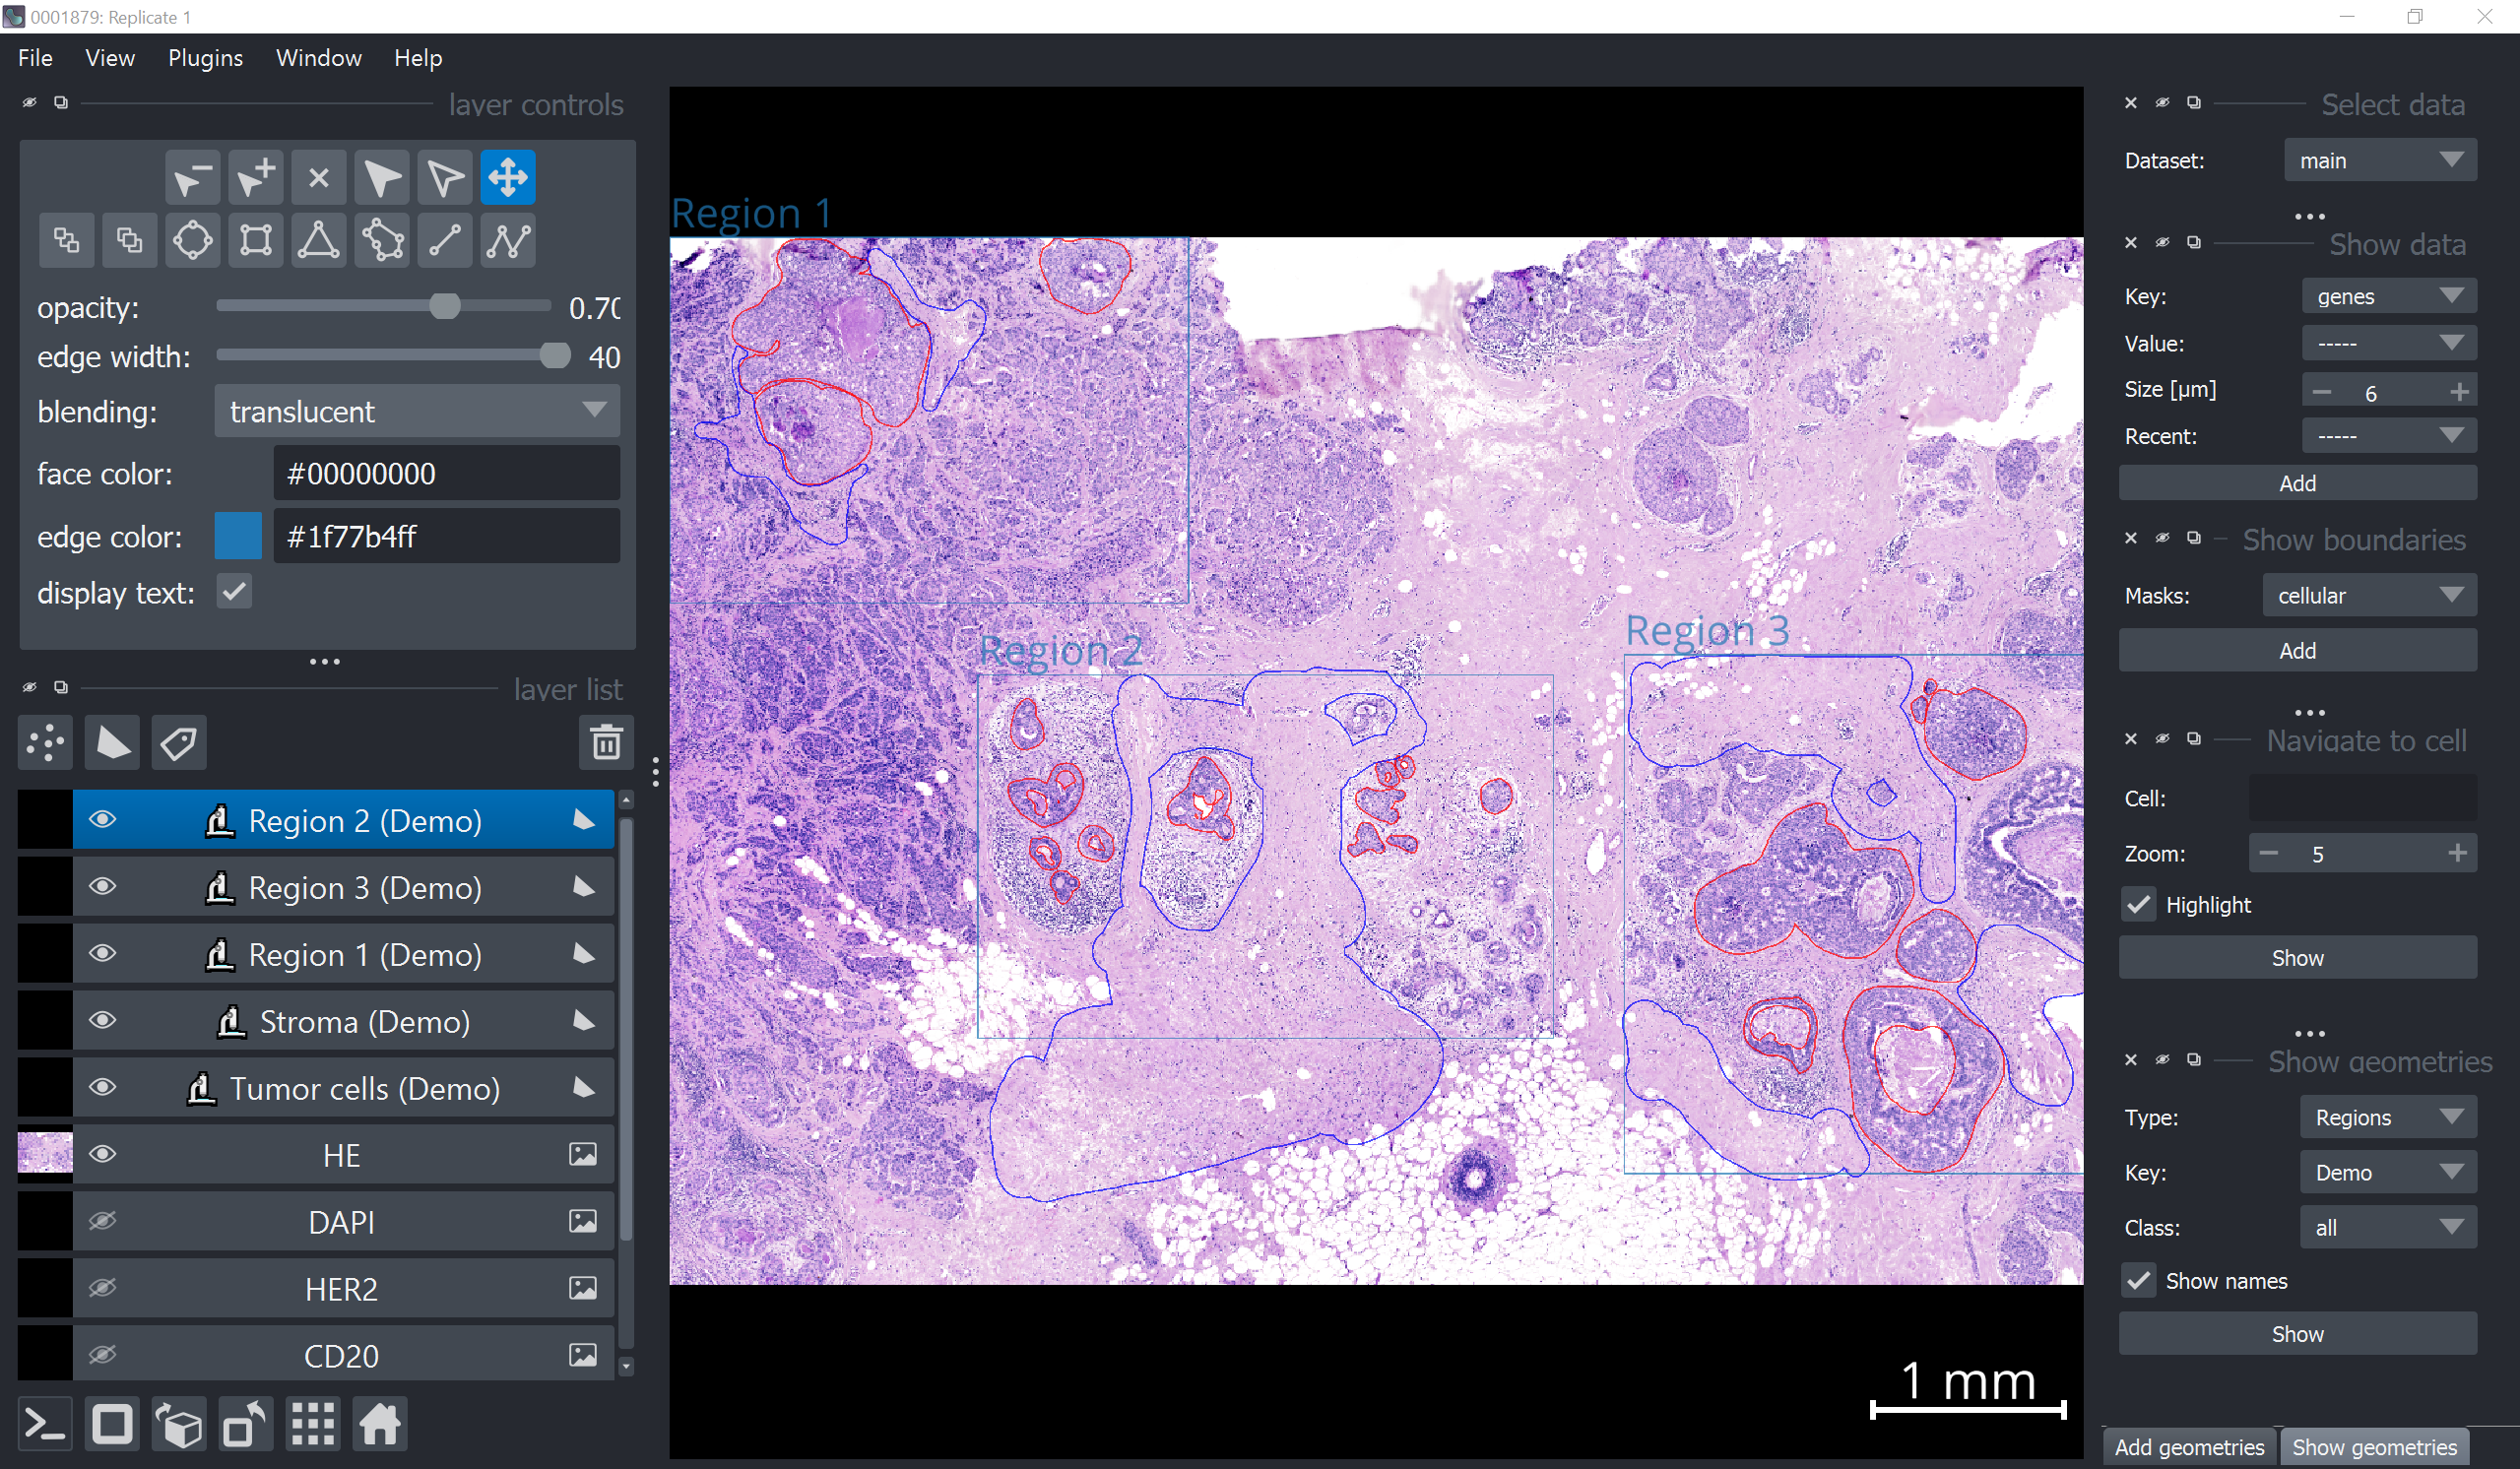

In [10]:
xd.show()

Invalid schema for package 'ome-types', please run 'npe2 validate ome-types' to check for manifest errors.


### Perform differential gene expression

In [11]:
from insitupy import differential_gene_expression

### Scenario 1: Comparison of two annotations within one dataset

Assigning key 'Demo'...
Added results to `.cells.matrix.obsm["annotations"]
Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.


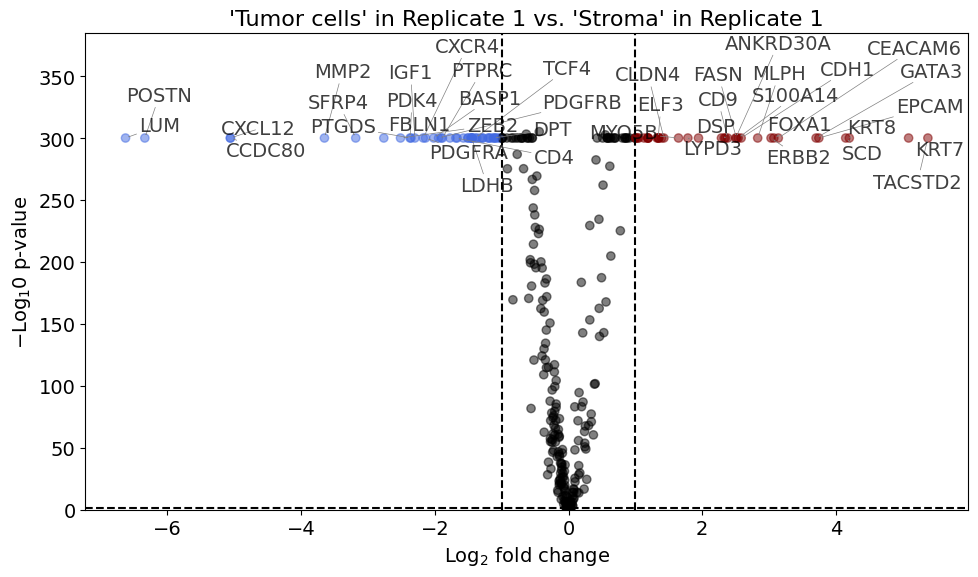

In [12]:
differential_gene_expression(
    data=xd,
    data_annotation_tuple=("Demo", "Tumor cells"),
    ref_annotation_tuple=("Demo", "Stroma"),
    ref_data=None,
    ignore_duplicate_assignments=True # if a cell is assigned to both the annotation and the reference, it is used only for the annotation
)

### Scenario 2: Comparison of two annotations within one dataset - restrict analysis to a specific region

Annotations with key 'Demo have already been assigned to `data`.
Assigning key 'Demo'...
Added results to `.cells.matrix.obsm["regions"]
Restrict analysis to region 'Region 3' from key 'Demo'.
Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.


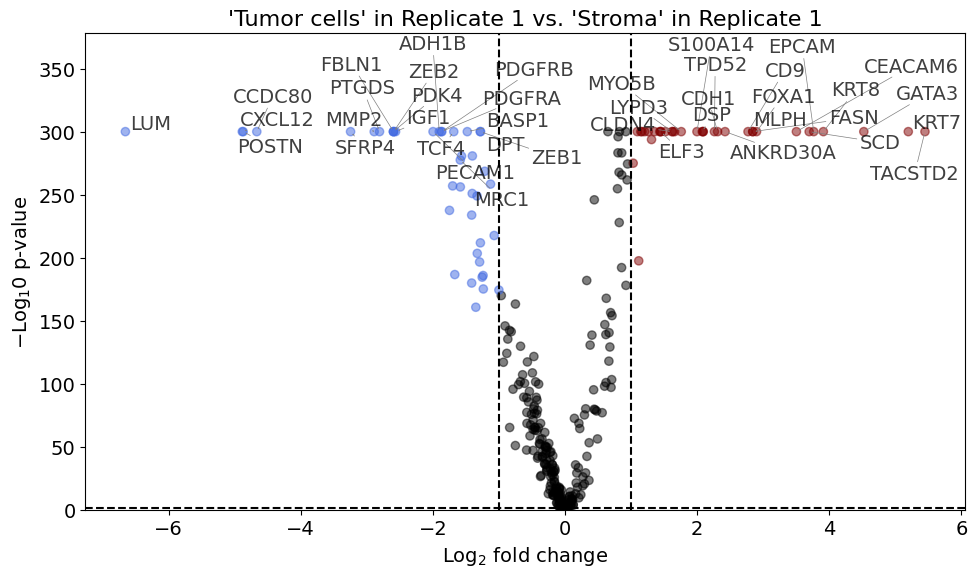

In [13]:
differential_gene_expression(
    data=xd,
    data_annotation_tuple=("Demo", "Tumor cells"),
    ref_annotation_tuple=("Demo", "Stroma"),
    ref_data=None,
    ignore_duplicate_assignments=True, # if a cell is assigned to both the annotation and the reference, it is used only for the annotation
    region_tuple=("Demo", "Region 3"),
)

### Scenario 3: Comparison of two annotations between two regions or datasets - restrict analysis to one cell type

In a first step the region annotations are used to split the dataset and create a `InSituExperiment` object.

In [14]:
from insitupy import InSituExperiment

In [15]:
exp = InSituExperiment.from_regions(
    data=xd,
    region_key="Demo",
    region_names=None # defaults to all regions
)

In [16]:
exp

InSituExperiment with 3 samples:
           uid slide_id    sample_id region_key region_name
0     d2d0da5e  0001879  Replicate 1       Demo    Region 1
1     b5448ba7  0001879  Replicate 1       Demo    Region 2
2     a85ca3fe  0001879  Replicate 1       Demo    Region 3

In a second step, the `dge()` function of `InSituExperiment` is used to setup the differential gene expression analysis. Here we compare the first and the second dataset and limit the analysis to Fibroblasts within the Stroma region.

Annotations with key 'Demo have already been assigned to `data`.
Annotations with key 'Demo have already been assigned to `data`.
Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.


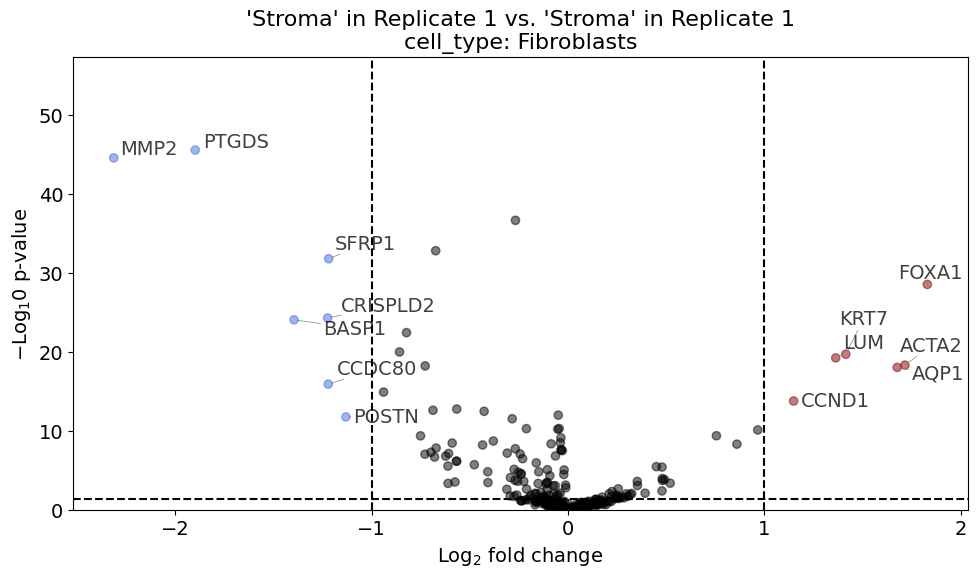

In [17]:
annotation = "Stroma"
cell_type = "Fibroblasts"

exp.dge(
    data_id=0,
    ref_id=1,
    data_annotation_tuple=("Demo", annotation),
    ref_annotation_tuple=("Demo", annotation),
    obs_tuple=("cell_type", cell_type),
)

### Scenario 4: Return results instead of Volcano plot

In [22]:
annotation = "Stroma"
cell_type = "Fibroblasts"

dge = exp.dge(
    data_id=0,
    ref_id=1,
    data_annotation_tuple=("Demo", annotation),
    ref_annotation_tuple=("Demo", annotation),
    obs_tuple=("cell_type", cell_type),
    plot_volcano=False
)

Annotations with key 'Demo have already been assigned to `data`.
Annotations with key 'Demo have already been assigned to `data`.
Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.


In [24]:
dge.keys()

dict_keys(['results', 'params'])

In [25]:
dge_results = dge['results']

## GO term enrichment analysis

Gene ontology (GO) term enrichment analysis can be performed via three different analysis platforms: [STRINGdb](https://string-db.org/), [g:Profiler](https://biit.cs.ut.ee/gprofiler/gost), and [Enrichr](https://maayanlab.cloud/Enrichr/).

In [26]:
from insitupy.utils.go import GOEnrichment
from insitupy.plotting.go import go_plot

In [27]:
pval_mask = dge_results['pvals'] < 0.05
lfc_mask_up = dge_results['logfoldchanges'] > 1
lfc_mask_down = dge_results['logfoldchanges'] < -1

genes_up = dge_results[lfc_mask_up & pval_mask]['gene'].tolist()
genes_down = dge_results[lfc_mask_down & pval_mask]['gene'].tolist()

In [28]:
# setup go term enrichment class
go = GOEnrichment()

# run go term enrichment analysis for up-regulated genes
go.stringdb(target_genes=genes_up, key_added='up',
             top_n=20, organism="hsapiens", return_df=False
             )
go.gprofiler(target_genes=genes_up, key_added='up',
             top_n=20, organism="hsapiens", return_df=False
             )
go.enrichr(target_genes=genes_up, key_added='up',
             top_n=20, organism="human", return_df=False
             )

# for down-regulated genes
go.stringdb(target_genes=genes_down, key_added='down',
             top_n=20, organism="hsapiens", return_df=False
             )
go.gprofiler(target_genes=genes_down, key_added='down',
             top_n=20, organism="hsapiens", return_df=False
             )
go.enrichr(target_genes=genes_down, key_added='down',
             top_n=20, organism="human", return_df=False
             )

The results are saved in the `GOEnrichment` class and can be accessed with the respective keys.

In [29]:
go

GOEnrichment analyses performed:
  stringdb:
    - up
    - down
  gprofiler:
    - up
    - down
  enrichr:
    - up
    - down

In [30]:
enrichment = go.results["gprofiler"]["down"]
enrichment.head()

source      native                              name   p_value  \
query 0  GO:CC  GO:0031012              extracellular matrix  0.000011   
      1  GO:CC  GO:0030312  external encapsulating structure  0.000011   
      2  GO:MF  GO:0008201                   heparin binding  0.000014   
      3  GO:MF  GO:0005539         glycosaminoglycan binding  0.000054   
      4  GO:MF  GO:1901681           sulfur compound binding  0.000075   

         significant                                        description  \
query 0         True  "A structure lying external to one or more cel...   
      1         True  "A structure that lies outside the plasma memb...   
      2         True  "Binding to heparin, a member of a group of gl...   
      3         True  "Binding to a glycan (polysaccharide) containi...   
      4         True  "Binding to a sulfur compound." [GOC:pr, GOC:T...   

         term_size  query_size  intersection_size  effective_domain_size  \
query 0        555           6                  5                  22097   
      1        556           6                  5                  22097   
      2        176           6                  4                  20212   
      3        247           6                  4                  20212   
      4        268           6                  4                  20212   

         precision  Gene ratio    query                   parents  \
query 0   0.833333    0.009009  query_1              [GO:0030312]   
      1   0.833333    0.008993  query_1  [GO:0071944, GO:0110165]   
      2   0.666667    0.022727  query_1  [GO:0005539, GO:1901681]   
      3   0.666667    0.016194  query_1              [GO:0097367]   
      4   0.666667    0.014925  query_1              [GO:0005488]   

                                  intersections  \
query 0  [POSTN, CCDC80, CRISPLD2, SFRP1, MMP2]   
      1  [POSTN, CCDC80, CRISPLD2, SFRP1, MMP2]   
      2        [POSTN, CCDC80, CRISPLD2, SFRP1]   
      3        [POSTN, CCDC80, CRISPLD2, SFRP1]   
      4        [POSTN, CCDC80, CRISPLD2, SFRP1]   

                                                 evidences  Enrichment score  
query 0  [[IDA, HDA, ISS, IBA, IEA], [IBA, IEA], [IEA],...          4.974404  
      1  [[IDA, HDA, ISS, IBA, IEA], [IBA, IEA], [IEA],...          4.970498  
      2                  [[ISS, IEA], [IEA], [IEA], [IDA]]          4.858791  
      3             [[ISS, IEA], [IEA], [IBA, IEA], [IDA]]          4.268210  
      4                  [[ISS, IEA], [IEA], [IEA], [IDA]]          4.126354

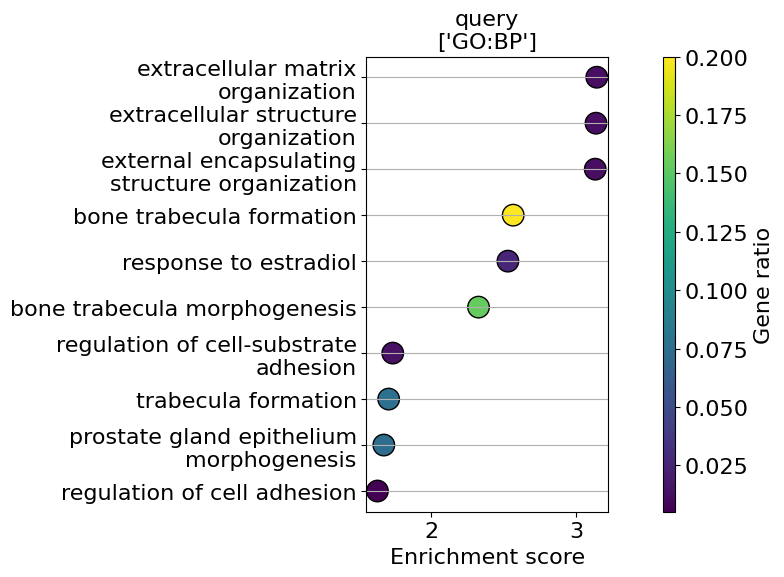

In [31]:
go_plot(enrichment=enrichment, style='dot', libraries='GO:BP')